# Assignment 2 : Regressions


## Introduction :

The Canadian border sees significant traffic flow from the US and this data is collected by The Government of Canada. In this project, we analyze the traffic flow to the Canadian border from the US using pandas in python. In addition to investigating the wait times for the passengers, we build two kinds of regression models namely OLS regression and logistic regression model to predict the wait time for passenger traveller flow at the Lewiston Bridge crossing. We then, analyze and compare both the models and discuss additional information and features which could potentially improve the models.


## Data:

We have used two publicly available datasets provided by The Government of Canada. The first dataset contains the information on wait times from the border crossings from 2010 to 2014 which we use to train our models and the second dataset contains the same information from 2015 which we use to predict the wait times and test our models. 
We have done a basic data cleaning process for both the datasets including dropping the columns and rows containing redundant information or missing information.

## Basic Data Exploration

Before we start to build the regression models to predict wait times, Let's explore our dataset and understand the data and relationships between different variables.

We start my importing the required libraries.

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

Let's import our first data set from 2008 -2014 

In [2]:
myfile = "/Users/nehaawasthi/Desktop/BANA/Assignment 2/bwt-taf-2010-2014-eng.csv"
df1 = pd.read_csv(myfile)

Let's do some basic data exploration

In [3]:
# Check the first 5 rows  of the dataframe
df1.head()

,CBSA Office,Location,Updated,Commercial Flow,Travellers Flow
0,St. Stephen,"St. Stephen, NB",2014-04-04 12:58 ADT,Not Applicable,No Delay
1,St. Stephen,"St. Stephen, NB",2014-04-04 11:55 ADT,Not Applicable,No Delay
2,St. Stephen,"St. Stephen, NB",2014-04-04 10:46 ADT,Not Applicable,No Delay
3,St. Stephen,"St. Stephen, NB",2014-04-04 10:14 ADT,Not Applicable,No Delay
4,St. Stephen,"St. Stephen, NB",2014-04-04 09:02 ADT,Not Applicable,No Delay


In [4]:
# Check the column-wise info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992993 entries, 0 to 992992
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CBSA Office      992993 non-null  object
 1   Location         992993 non-null  object
 2   Updated          992993 non-null  object
 3   Commercial Flow  992993 non-null  object
 4   Travellers Flow  992993 non-null  object
dtypes: object(5)
memory usage: 37.9+ MB


In [5]:
# check the type of data for each column
df1.dtypes

CBSA Office        object
Location           object
Updated            object
Commercial Flow    object
Travellers Flow    object
dtype: object

In [6]:
# Check the shape of the dataframe
df1.shape

(992993, 5)

## Data Analysis for Queenston-Lewiston Bridge

We want to analyze the wait times for Queenston-Lewiston Bridge only so, let's subset the dataset for that particular office and then explore and clean-up the data here. 

In [7]:
# Get data only for Queenston-Lewiston Bridge
filtered_df1 = df1[df1['CBSA Office'] == 'Queenston-Lewiston Bridge']
filtered_df1.head()

,CBSA Office,Location,Updated,Commercial Flow,Travellers Flow
369413,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 13:06 EDT,No Delay,No Delay
369414,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 12:05 EDT,No Delay,No Delay
369415,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:09 EDT,No Delay,No Delay
369416,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:07 EDT,No Delay,No Delay
369417,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:07 EDT,No Delay,No Delay


Let's check the unique items in the Travellers flow column for the passenger wait times

In [8]:
filtered_df1['Travellers Flow'].value_counts()

No Delay    35675
10           2493
20           2043
30           1986
45           1455
60            294
75            171
90             53
105            20
120            16
Closed         12
150             7
135             5
420             4
Name: Travellers Flow, dtype: int64

As we ultimately want to run regression models of this data, let's investigate the 'Closed' values more

In [9]:
# Let's check the values when 'Travellers Flow' was closed for any of the locations
df1[df1['Travellers Flow'] == 'Closed'].head()

,CBSA Office,Location,Updated,Commercial Flow,Travellers Flow
6386,St. Stephen,"St. Stephen, NB",2013-08-10 13:21 ADT,Not Applicable,Closed
6388,St. Stephen,"St. Stephen, NB",2013-08-10 13:21 ADT,Not Applicable,Closed
16760,St. Stephen,"St. Stephen, NB",2012-08-11 14:35 ADT,Not Applicable,Closed
16761,St. Stephen,"St. Stephen, NB",2012-08-11 14:35 ADT,Not Applicable,Closed
34288,St. Stephen,"St. Stephen, NB",2010-12-04 12:02 ADT,Not Applicable,Closed


Now, let's see the 'Closed' entries only for 'Queenston-Lewiston Bridge'.

There are only 12 closed values for this dataframe and upon inspection they don't seem to have anything in common with closed entries from other enrty points.

Upon further investigation, we found out that on the mentioned dates of 28th & 29th April 2011, The Niagara Falls Bridge Commission closed the Lewiston-Queenston Bridge due to the damage and power outages caused by high winds
(https://www.wbfo.org/2011-04-28/high-winds-close-lewiston-queenston-bridge).
Since, this doesn't seem to be a systemic problem we have decided to drop the 'Closed' value entries so as not to skew our analysis.

In [10]:
# Let's drop the "Closed" entries for "Travellers Flow"
indexFiltered = filtered_df1[(filtered_df1['Travellers Flow'] == "Closed")].index
filtered_df1.drop(indexFiltered, axis =0,  inplace=True)

## Feature Engineering

Now that we have cleaned data for the desired location, let's build the features from here which will be useful in our regression models predicting Travellers wait times.

Here, we convert the 'Updated' column from the dataframe containing the datetime information to datetime variable and extract different informstion to create new features.

In [11]:
# Let's create new features for Date, Month, Year, Time, Hour and Weekday 
filtered_df1['Date'] = pd.to_datetime(filtered_df1['Updated']).dt.date
filtered_df1['Month'] = pd.to_datetime(filtered_df1['Updated']).dt.month
filtered_df1['Year'] = pd.to_datetime(filtered_df1['Updated']).dt.year
filtered_df1['Time_of_Day'] = pd.to_datetime(filtered_df1['Updated']).dt.time
filtered_df1['Hour'] = pd.to_datetime(filtered_df1['Updated']).dt.hour
filtered_df1['Day of Week'] = pd.to_datetime(filtered_df1['Updated']).dt.weekday
filtered_df1['Day'] = pd.to_datetime(filtered_df1['Updated']).dt.day

In [12]:
#Let's create a season feature based on New York Seasons
season_con =[(filtered_df1['Month'] > 6) & (filtered_df1['Month'] <= 9),(filtered_df1['Month']>= 10) & 
             (filtered_df1['Month']<= 12),(filtered_df1['Month']>= 1)& 
             (filtered_df1['Month'] <= 3),(filtered_df1['Month'] >= 4)& (filtered_df1['Month']<= 6)]
season_options = ['Summer', 'Autumn', 'Winter', 'Spring']

filtered_df1['Season'] = np.select(season_con, season_options, default=np.nan)

Now, we look at the distribution of 'Hour' variable to categorize it.

<AxesSubplot:ylabel='Frequency'>

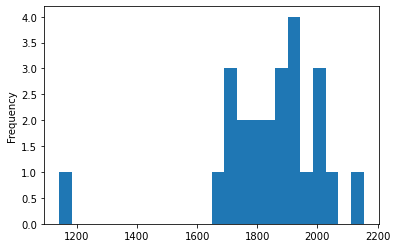

In [13]:
# histogram of unique values
filtered_df1['Hour'].value_counts().plot(kind='hist', bins =24)

Let's add another variable categorizing whether the day was holiday or not according to US federal Holiday Calendar.

In [14]:
# create a Holiday variable
cal = calendar()
holidays = cal.holidays(start=filtered_df1['Date'].min(),end=filtered_df1['Date'].max())
filtered_df1['Holiday']= filtered_df1['Date'].isin(holidays)
filtered_df1.head()

,CBSA Office,Location,Updated,Commercial Flow,Travellers Flow,Date,Month,Year,Time_of_Day,Hour,Day of Week,Day,Season,Holiday
369413,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 13:06 EDT,No Delay,No Delay,2014-04-04,4,2014,13:06:00,13,4,4,Spring,False
369414,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 12:05 EDT,No Delay,No Delay,2014-04-04,4,2014,12:05:00,12,4,4,Spring,False
369415,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:09 EDT,No Delay,No Delay,2014-04-04,4,2014,11:09:00,11,4,4,Spring,False
369416,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:07 EDT,No Delay,No Delay,2014-04-04,4,2014,11:07:00,11,4,4,Spring,False
369417,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:07 EDT,No Delay,No Delay,2014-04-04,4,2014,11:07:00,11,4,4,Spring,False


## Exploratory Data Analysis

Now that we have added the features in our dataframe, let's analyse the distribution of each feature and their relationship with wait time variable for Travellers Flow.

Let's start with Day of the week.
First, we plot a bar plot and a box plot to visualise the distribution:

<AxesSubplot:>

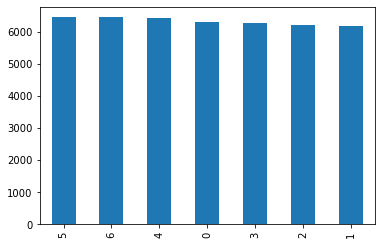

In [15]:
# Bar Graph of Day of the week
filtered_df1['Day of Week'].value_counts().plot(kind='bar')

<AxesSubplot:>

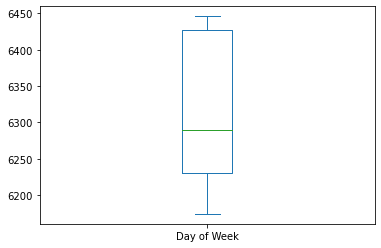

In [16]:
# Box plot of Day of the week
filtered_df1['Day of Week'].value_counts().plot(kind='box')

The traffic looks pretty evenly distributed for the days of the week.

Let's also study the relationship between Days of the week and the Travellers Flow using catplot:

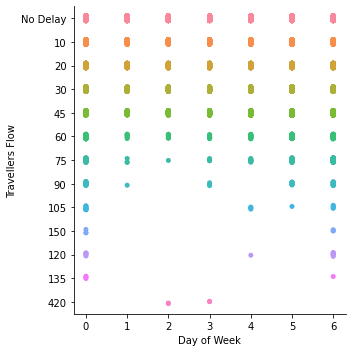

In [17]:
sns.catplot(data=filtered_df1, x="Day of Week", y="Travellers Flow")

Let's categorize the days of the week into weekdays and weekends:

In [18]:
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 0, 'Weekend', inplace =True)
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 1, 'Weekday', inplace =True)
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 2, 'Weekday', inplace =True)
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 3, 'Weekday', inplace =True)
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 4, 'Weekday', inplace =True)
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 5, 'Weekday', inplace =True)
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 6, 'Weekend', inplace =True)
filtered_df1.head()

,CBSA Office,Location,Updated,Commercial Flow,Travellers Flow,Date,Month,Year,Time_of_Day,Hour,Day of Week,Day,Season,Holiday
369413,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 13:06 EDT,No Delay,No Delay,2014-04-04,4,2014,13:06:00,13,Weekday,4,Spring,False
369414,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 12:05 EDT,No Delay,No Delay,2014-04-04,4,2014,12:05:00,12,Weekday,4,Spring,False
369415,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:09 EDT,No Delay,No Delay,2014-04-04,4,2014,11:09:00,11,Weekday,4,Spring,False
369416,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:07 EDT,No Delay,No Delay,2014-04-04,4,2014,11:07:00,11,Weekday,4,Spring,False
369417,Queenston-Lewiston Bridge,"Queenston, ON",2014-04-04 11:07 EDT,No Delay,No Delay,2014-04-04,4,2014,11:07:00,11,Weekday,4,Spring,False


Like the day of the week, let's analyze all the added features and their relationships with the wait times:

#### Distribution of Travellers Flow:

<AxesSubplot:>

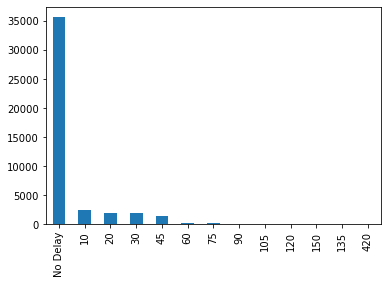

In [19]:
# Bar plot
filtered_df1['Travellers Flow'].value_counts().plot(kind='bar')

#### Distribution & Relationship of Days of the month with wait times:

<AxesSubplot:>

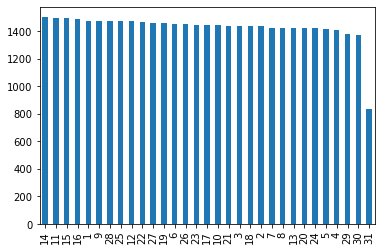

In [20]:
# Bar Graph of Days of the month
filtered_df1['Day'].value_counts().plot(kind='bar')

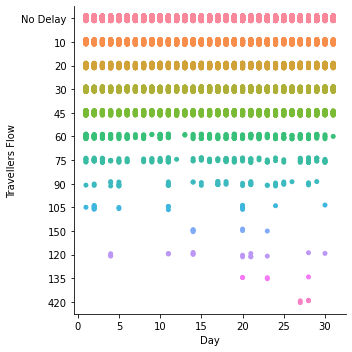

In [21]:
# Catplot
sns.catplot(data=filtered_df1, x="Day", y="Travellers Flow")

#### Distribution & Relationship of Years with wait times:

<AxesSubplot:>

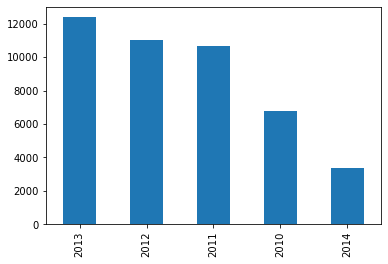

In [22]:
# Bar Graph for year
filtered_df1['Year'].value_counts().plot(kind='bar')

<AxesSubplot:>

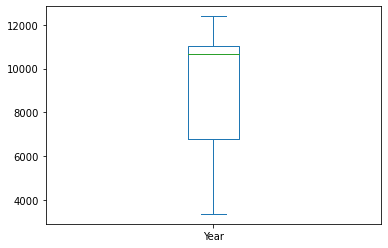

In [23]:
# Box plot for year
filtered_df1['Year'].value_counts().plot(kind='box')

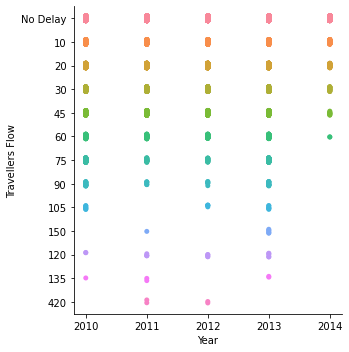

In [24]:
# Catplot for the relationship between Year and Travellers flow
sns.catplot(data=filtered_df1, x="Year", y="Travellers Flow")

#### Distribution & Relationship of Month with wait times:

<AxesSubplot:>

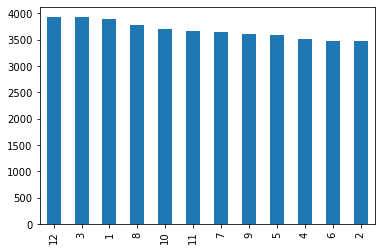

In [25]:
# Box plot
filtered_df1['Month'].value_counts().plot(kind='bar')

<AxesSubplot:>

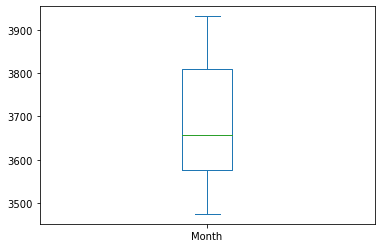

In [26]:
# Box plot
filtered_df1['Month'].value_counts().plot(kind='box')

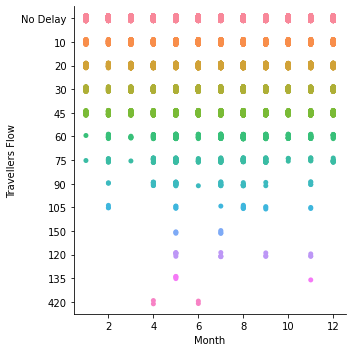

In [27]:
# Catplot for the relationship between Year and Travellers flow
sns.catplot(data=filtered_df1, x="Month", y="Travellers Flow")

#### Distribution & Relationship of Season with wait times

<AxesSubplot:>

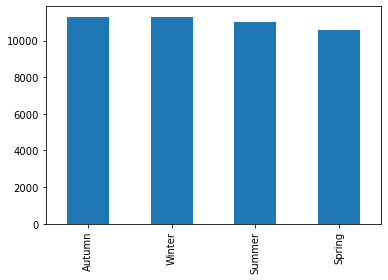

In [28]:
# Box plot
filtered_df1['Season'].value_counts().plot(kind='bar')

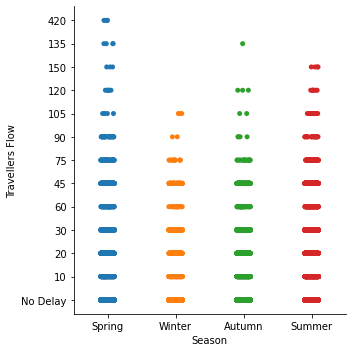

In [29]:
# Catplot for the relationship between Year and Travellers flow
sns.catplot(data=filtered_df1, x="Season", y="Travellers Flow")

We see that Spring is the most travelled season and winter is the least travelled one.

#### Distribution of Holiday for observations:

<AxesSubplot:>

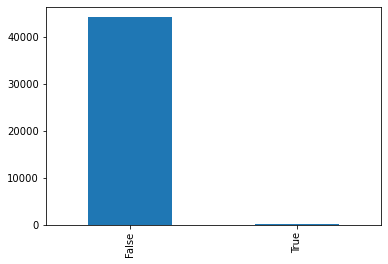

In [30]:
# Bar plot of Holiday
filtered_df1['Holiday'].value_counts().plot(kind='bar')

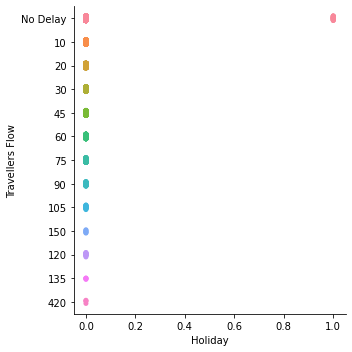

In [31]:
sns.catplot(data=filtered_df1, x="Holiday", y="Travellers Flow")

Let's import the second dataset for testing and repeat the same steps for features as the first dataset.

In [32]:
# read in the dataset
df2 = pd.read_csv("/Users/nehaawasthi/Desktop/BANA/Assignment 2/bwt-taf-2015-01-01--2015-03-31-en.csv")

In [33]:
# filter data for just Queenston-Lewiston Bridge
filtered_df2 = df2[df2['CBSA Office'] == 'Queenston-Lewiston Bridge']

In [34]:
# drop Closed values in Travellers Flow
indexfiltered = filtered_df2[(filtered_df2['Travellers Flow'] == "Closed")].index
filtered_df2.drop(indexfiltered, axis =0,  inplace=True)

In [35]:
# Create new time, date, month, year, hour, day of the week, day of the month variables
filtered_df2['Date'] = pd.to_datetime(filtered_df2['Updated']).dt.date
filtered_df2['Month'] = pd.to_datetime(filtered_df2['Updated']).dt.month
filtered_df2['Year'] = pd.to_datetime(filtered_df2['Updated']).dt.year
filtered_df2['Time_of_Day'] = pd.to_datetime(filtered_df2['Updated']).dt.time
filtered_df2['Hour'] = pd.to_datetime(filtered_df2['Updated']).dt.hour
filtered_df2['Day of Week'] = pd.to_datetime(filtered_df2['Updated']).dt.weekday
filtered_df2['Day'] = pd.to_datetime(filtered_df2['Updated']).dt.day

In [36]:
# Create variables for seasons
season_con =[(filtered_df2['Month'] > 6) & (filtered_df2['Month'] <= 9),(filtered_df2['Month']>= 10) & 
             (filtered_df2['Month']<= 12),(filtered_df2['Month']>= 1)& 
             (filtered_df2['Month'] <= 3),(filtered_df2['Month'] >= 4)& (filtered_df2['Month']<= 6)]
season_options = ['Summer', 'Autumn', 'Winter', 'Spring']

filtered_df2['Season'] = np.select(season_con, season_options, default=np.nan)

In [37]:
# create holiday variable
cale = calendar()
holidays = cale.holidays(start=filtered_df2['Date'].min(),end=filtered_df2['Date'].max())
filtered_df2['Holiday']= filtered_df2['Date'].isin(holidays)

In [38]:
# drop missed entries
filtered_df2 = filtered_df2[filtered_df2['Travellers Flow'] != 'Missed entry']

## Regression Models:
Let's manipulate the datasets so as to fit the data for the models. We will create different wait time columns for both the models and create different numeric variables for modeling. 

In [39]:
# Create the two wait time columns for OLS (Continuous) and logistic (Categorical) regression
filtered_df1['Continuous Wait Time'] = filtered_df1['Travellers Flow']
filtered_df1['Categorical Wait Time'] = filtered_df1['Travellers Flow']
filtered_df2['Continuous Wait Time'] = filtered_df2['Travellers Flow']
filtered_df2['Categorical Wait Time'] = filtered_df2['Travellers Flow']

In [40]:
# Convert column values to numeric for modeling
filtered_df1['Continuous Wait Time'].mask(filtered_df1['Continuous Wait Time'] == 'No Delay', 0, inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == 'No Delay', 'Low', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '10', 'Low', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '20', 'Low', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '30', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '45', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '60', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '75', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '90', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '105', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '120', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '135', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '150', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == '420', 'High', inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == 'Low', 0, inplace=True)
filtered_df1['Categorical Wait Time'].mask(filtered_df1['Categorical Wait Time'] == 'High', 1, inplace=True)
filtered_df1['Holiday'].mask(filtered_df1['Holiday'] == False, 0, inplace=True)
filtered_df1['Holiday'].mask(filtered_df1['Holiday'] == True, 1, inplace=True)
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 'Weekday', 0, inplace=True)
filtered_df1['Day of Week'].mask(filtered_df1['Day of Week'] == 'Weekend', 1, inplace=True)
filtered_df1['Season'].mask(filtered_df1['Season'] == 'Summer', 1, inplace=True)
filtered_df1['Season'].mask(filtered_df1['Season'] == 'Autumn', 2, inplace=True)
filtered_df1['Season'].mask(filtered_df1['Season'] == 'Winter', 3, inplace=True)
filtered_df1['Season'].mask(filtered_df1['Season'] == 'Spring', 4, inplace=True)
filtered_df2['Continuous Wait Time'].mask(filtered_df2['Continuous Wait Time'] == 'No delay', 0, inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == 'No delay', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '1', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '2', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '3', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '4', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '5', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '6', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '7', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '8', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '9', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '10', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '11', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '12', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '13', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '14', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '15', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '16', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '17', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '18', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '19', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '20', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '21', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '22', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '23', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '24', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '25', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '26', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '27', 'Low', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '28', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '29', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '30', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '31', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '32', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '33', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '34', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '35', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '36', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '40', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '41', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '42', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '43', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == '44', 'High', inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == 'Low', 0, inplace=True)
filtered_df2['Categorical Wait Time'].mask(filtered_df2['Categorical Wait Time'] == 'High', 1, inplace=True)
filtered_df2['Holiday'].mask(filtered_df2['Holiday'] == False, 0, inplace=True)
filtered_df2['Holiday'].mask(filtered_df2['Holiday'] == True, 1, inplace=True)
filtered_df2['Day of Week'].mask(filtered_df2['Day of Week'] == 'Weekday', 0, inplace=True)
filtered_df2['Day of Week'].mask(filtered_df2['Day of Week'] == 'Weekend', 1, inplace=True)
filtered_df2['Season'].mask(filtered_df2['Season'] == 'Summer', 1, inplace=True)
filtered_df2['Season'].mask(filtered_df2['Season'] == 'Autumn', 2, inplace=True)
filtered_df2['Season'].mask(filtered_df2['Season'] == 'Winter', 3, inplace=True)
filtered_df2['Season'].mask(filtered_df2['Season'] == 'Spring', 4, inplace=True)

Export the cleaned data sets and read them back in for training and testing.

In [41]:
# Export cleaned dataset to csv to read in for modeling
filtered_df1.to_csv('/Users/nehaawasthi/Desktop/BANA/Assignment 2/Train_Data.csv')
filtered_df2.to_csv('/Users/nehaawasthi/Desktop/BANA/Assignment 2/Test_Data.csv')

In [42]:
# Read back in the datasets cleaned for modeling
Train = pd.read_csv('/Users/nehaawasthi/Desktop/BANA/Assignment 2/Train_Data.csv')
Test = pd.read_csv('/Users/nehaawasthi/Desktop/BANA/Assignment 2/Test_Data.csv')

In [43]:
# rename columns to be inserted into models
Train.rename(columns = {'Day of Week':'Day_of_Week', 'Continuous Wait Time':'Continuous_Wait_Time', 'Categorical Wait Time':'Categorical_Wait_Time'}, inplace = True)
Test.rename(columns = {'Day of Week':'Day_of_Week', 'Continuous Wait Time':'Continuous_Wait_Time', 'Categorical Wait Time':'Categorical_Wait_Time'}, inplace = True)

## OLS Regression Model
We will use relevant variables from our analysis and run the OLS regression model first.

In [44]:
# fit our OLS model based on the relevant variables
fl = "Continuous_Wait_Time ~ Holiday + Day_of_Week + Hour + Year + Day + Season"
ols_model = sm.ols(formula=fl, data=Train).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Continuous_Wait_Time   R-squared:                       0.101
Model:                              OLS   Adj. R-squared:                  0.101
Method:                   Least Squares   F-statistic:                     827.8
Date:                  Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                          11:03:05   Log-Likelihood:            -1.7646e+05
No. Observations:                 44222   AIC:                         3.529e+05
Df Residuals:                     44215   BIC:                         3.530e+05
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -196.6775    105.367     -1.867      0.062    -403.198       9.843
Holiday        -4.2957      2.674     -1.606      0.108      -9.537       0.946
Day_of_Week     3.6256      0.137     26.377      0.000       3.356       3.895
Hour            0.5449      0.009     60.819      0.000       0.527       0.562
Year            0.0980      0.052      1.871      0.061      -0.005       0.201
Day             0.0290      0.007      4.096      0.000       0.015       0.043
Season         -1.2892      0.056    -22.861      0.000      -1.400      -1.179
==============================================================================
Omnibus:                    50744.671   Durbin-Watson:                   0.545
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20145617.924
Skew:                           5.496   Prob(JB):                         0.00
Kurtosis:                     106.983   Cond. No.                     3.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# define the dependent and independent variables
XTest1 = Test[['Holiday','Day_of_Week','Hour','Year','Day', 'Season']]
YTest1 = Test['Continuous_Wait_Time']
  
# perform predictions on the test datdaset
yhat1 = ols_model.predict(XTest1)
prediction1 = list(map(round, yhat1))

In [46]:
# get the confusion matrix
cm = confusion_matrix(YTest1, prediction1) 
print ("Confusion Matrix : \n", cm) 
  
# check the accuracy score of the model
print('Test accuracy = ', accuracy_score(YTest1, prediction1))

Confusion Matrix : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Test accuracy =  0.014836109756410585


The extremely low R-squared and test accuracy suggest that this is not a good model to predict Traveller's wait times.

### Logistic Model
Let's build a logistic regression model using the same variables.

In [47]:
# fit our Logistic model
f2 = "Categorical_Wait_Time ~ Holiday + Day_of_Week+ Month + Season + Hour + Day + Year"
logit_model = sm.logit(formula=f2, data=Train).fit()
logit_model.summary()

         Current function value: 0.262111
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     Categorical_Wait_Time   No. Observations:                44222
Model:                             Logit   Df Residuals:                    44214
Method:                              MLE   Df Model:                            7
Date:                   Fri, 18 Nov 2022   Pseudo R-squ.:                  0.1382
Time:                           11:03:05   Log-Likelihood:                -11591.
converged:                         False   LL-Null:                       -13450.
Covariance Type:               nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -53.4025     30.687     -1.740      0.082    -113.547       6.742
Holiday       -10.9188    166.997     -0.065      0.948    -338.227     316.389
Day_of_Week     0.8164      0.035     23.029      0.000       0.747       0.886
Month           0.0097      0.006      1.524      0.127      -0.003       0.022
Season         -0.3447      0.020    -17.418      0.000      -0.384      -0.306
Hour            0.1451      0.003     46.178      0.000       0.139       0.151
Day             0.0060      0.002      3.029      0.002       0.002       0.010
Year            0.0245      0.015      1.609      0.108      -0.005       0.054
===============================================================================
"""

In [48]:
# define the dependent and independent variables
XTest2 = Test[['Holiday','Day_of_Week','Hour','Year','Day', 'Month', 'Season']]
YTest2 = Test['Categorical_Wait_Time'] 
  
# perform the predictions on the test datdaset
yhat2 = logit_model.predict(XTest2)
prediction2 = list(map(round, yhat2))

Run the confusion matrix and get the accuracy

In [49]:
# Get confusion matrix
cm = confusion_matrix(YTest2, prediction2) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(YTest2, prediction2))

Confusion Matrix : 
 [[24871 14057]
 [    0    31]]
Test accuracy =  0.6391847840036962


We ran mutiple variations of the model tinkering with various features and dropped the insignificant variables and used the variables that yeild the best accuracy.

We now run the best logistic regression model we got by using the given variables.

In [50]:
# fit our Logistic model
f2 = "Categorical_Wait_Time ~ Day_of_Week+ Hour + Day + Holiday + Month"
logit_model = sm.logit(formula=f2, data=Train).fit()
logit_model.summary()

         Current function value: 0.265679
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     Categorical_Wait_Time   No. Observations:                44222
Model:                             Logit   Df Residuals:                    44216
Method:                              MLE   Df Model:                            5
Date:                   Fri, 18 Nov 2022   Pseudo R-squ.:                  0.1265
Time:                           11:03:05   Log-Likelihood:                -11749.
converged:                         False   LL-Null:                       -13450.
Covariance Type:               nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.2395      0.075    -69.482      0.000      -5.387      -5.092
Day_of_Week     0.8106      0.035     23.012      0.000       0.742       0.880
Hour            0.1438      0.003     46.059      0.000       0.138       0.150
Day             0.0059      0.002      2.975      0.003       0.002       0.010
Holiday       -14.5550    938.808     -0.016      0.988   -1854.585    1825.475
Month           0.0691      0.005     13.773      0.000       0.059       0.079
===============================================================================
"""

In [51]:
# define the dependent and independent variables
XTest2 = Test[['Day_of_Week','Hour', 'Day', 'Month', 'Holiday']]
YTest2 = Test['Categorical_Wait_Time'] 
  
# perform the predictions on the test datdaset
yhat2 = logit_model.predict(XTest2)
prediction2 = list(map(round, yhat2))

In [52]:
# Get confusion matrix
cm = confusion_matrix(YTest2, prediction2) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(YTest2, prediction2))

Confusion Matrix : 
 [[26036 12892]
 [    3    28]]
Test accuracy =  0.6690110115762725


The test accuracy as we see is 66.9%.

## Conclusion:

We can see that when we try to predict the same wait time variable using OLS and Logistic regression model, the logistic regression model does a much more accurate job of predicting the wait times for Travellers Flow.
This is not surprising as the variable that we are trying to predict has some discrete values and will be better predicted as a categorical variable and thus the logistic regression is a better model for this data. We also know that OLS does a good job of predicting variables that have a linear relationship with the features. Here, we didn't see any evidence of that and all our independent variables are also categorical. Hence, Logistic regression is the best model for this data.

## Additional Considerations:

While these are the best models we got from the data present in our dataset, we could improve our models if we could get some additional information and add features. For instance, if we had data on the weather for all the observations, we could have factored that in for the impact on the wait times. Similarly, if we had the information on the nationalities of the passenger we could see their relationship with time taken to cross the port. Pedestrians also take less time to cross so if we have that information, it could improve the model too. If we have information about the maintenance work at the crossings, we could incorporate that into our features too. Access to any or all of this information, could potentially make our model better.
